In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Import Pythia Dataset

In [2]:
with uproot.open("/home/lvaughan/Pythia/pythia/PU_dataset/dataset_mu60.root:pythia") as f:
    trk_pt = f["pT"].array()
    trk_eta = f["eta"].array()
    trk_phi = f["phi"].array()
    trk_label = f["label"].array()
    trk_q = f["q"].array()
with uproot.open("/home/lvaughan/Pythia/pythia/PU_dataset/dataset_mu60.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    trk_ID = f["trk_ID"].array()

### Define Jet Class

In [3]:
class Jet:
    def __init__(self, jet_features, trk_features, trk_labels):
        self.jet_features = jet_features
        self.trk_features = trk_features
        self.trk_labels = trk_labels
        
    def get_label(self):
        sum_pt_hs = 0
        sum_pt_pu = 0.0000001
        for trk in range(len(self.trk_features)):
            if self.trk_labels[trk]==-1:
                sum_pt_hs+=self.trk_features[trk,0]**2
            else:
                sum_pt_pu+=self.trk_features[trk,0]**2
        return sum_pt_hs / (sum_pt_hs + sum_pt_pu)
    
    def set_label(self, label):
        self.label = np.float32(label)
        
    def convert_to_tensor(self):
        self.trk_features = torch.from_numpy(self.trk_features)
        self.jet_features = torch.from_numpy(self.jet_features)
        self.label = torch.tensor(self.label).reshape([1])

### Read Raw Data into Jet Class

In [4]:
num_jets = len(jet_pt)

Jets = []

for jet in range(num_jets):
    if jet%100==0:
        print("Processing: ", jet, " / ", num_jets, end="\r")
    if jet_eta[jet] > 4:
        continue
    jet_feats = np.array([jet_pt[jet],jet_eta[jet],jet_phi[jet]], dtype=np.float32)
    trk_feats = np.empty((0,4), dtype=np.float32)
    for trk in trk_ID[jet]:
        # ALTAS uses 400MeV cut
        if trk_pt[trk] < 0.4:
            continue
        # Implement eta cuts on tracks
        if trk_eta[trk] > 4:
            continue
        # Skip neutral particles
        if trk_q[trk]==0:
            continue
        trk_feats = np.vstack((trk_feats, np.array([trk_pt[trk], trk_eta[trk], trk_phi[trk], trk_label[trk]], dtype=np.float32)))
    Jets.append(Jet(jet_feats,trk_feats[:,0:3],trk_feats[:,-1]))
    
random.shuffle(Jets)

Jets_training = Jets[0:int(0.6*num_jets)]
Jets_validation = Jets[int(0.6*num_jets):int(0.7*num_jets)]
Jets_testing = Jets[int(0.7*num_jets):-1]

print()
print("Training samples: ", len(Jets_training))
print("Validation samples: ", len(Jets_validation))
print("Testing samples: ", len(Jets_testing))

Processing:  44600  /  44634
Training samples:  26780
Validation samples:  4463
Testing samples:  11142


### Plot Labels

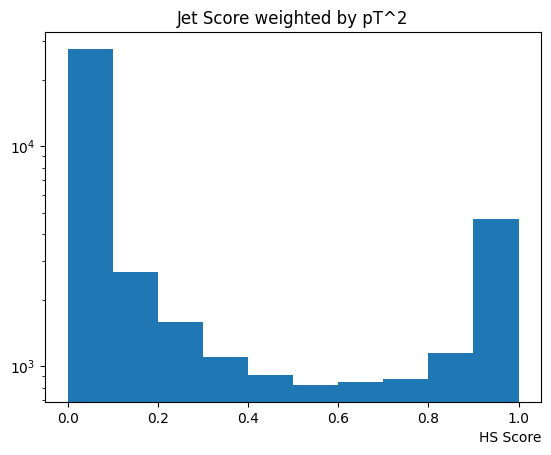

In [5]:
label = []
for jet in Jets:
    jet.set_label(jet.get_label())
    jet.convert_to_tensor()
    label.append(float(jet.label[0].numpy()))
    
plt.hist(label)
plt.title("Jet Score weighted by pT^2")
plt.xlabel("HS Score",loc='right')
plt.yscale('log')

### Define Model

In [6]:
class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 64
        self.num_heads = 8
        self.num_feats = 3
        
        self.jet_initializer = nn.Linear(self.num_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_feats, self.embed_dim)
        
        self.multihead_attn = nn.MultiheadAttention(self.embed_dim, self.num_heads)
        
        self.regression = nn.Linear(self.embed_dim*2, 1)
        
    def forward(self, jet_feats, trk_feats):
        trk_init = F.relu(self.trk_initializer(trk_feats))
        jet_init = F.relu(self.jet_initializer(jet_feats))
        
        query = trk_init
        key = trk_init
        value = trk_init
        
        trk_embedding, trk_weights = self.multihead_attn(query, key, value)
        
        num_trks = trk_embedding.shape[0]
        trk_aggregated = torch.zeros(self.embed_dim).to(device)
        for trk in range(num_trks):
            trk_aggregated = torch.add(trk_aggregated, trk_embedding[trk])
            
        jet_embedding = torch.cat((jet_init, trk_aggregated))
                
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output, trk_weights

### Define Training Loop

In [7]:
def train(model, data, epochs=20):
    train_data, validation_data = data
    
    history = []
    num_train = len(train_data)
    num_val = len(validation_data)
    
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0
        for entry in train_data:
            optimizer.zero_grad()
            output, weights = model(entry.jet_features.to(device), entry.trk_features.to(device))
            loss=loss_fn(output, entry.label.to(device))
            loss.backward()
            optimizer.step()
            cumulative_loss_train+=loss.detach().cpu().numpy()
        cumulative_loss_train = cumulative_loss_train / num_train
        
        model.eval()
        cumulative_loss_val = 0
        for entry in validation_data:
            output, weights = model(entry.jet_features.to(device), entry.trk_features.to(device))
            loss=loss_fn(output, entry.label.to(device))
            cumulative_loss_val+=loss.detach().cpu().numpy()
        cumulative_loss_val = cumulative_loss_val / num_val
        
        history.append([cumulative_loss_train, cumulative_loss_val])

        print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))

    return history

In [8]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


Epoch: 0 	Train Loss: 0.249046 	Val Loss: 0.105594
Epoch: 1 	Train Loss: 0.088194 	Val Loss: 0.07801
Epoch: 2 	Train Loss: 0.072717 	Val Loss: 0.06775
Epoch: 3 	Train Loss: 0.064672 	Val Loss: 0.06205
Epoch: 4 	Train Loss: 0.059894 	Val Loss: 0.058849
Epoch: 5 	Train Loss: 0.057015 	Val Loss: 0.056715
Epoch: 6 	Train Loss: 0.055114 	Val Loss: 0.055173
Epoch: 7 	Train Loss: 0.05382 	Val Loss: 0.054141
Epoch: 8 	Train Loss: 0.052987 	Val Loss: 0.053486
Epoch: 9 	Train Loss: 0.052458 	Val Loss: 0.053047
Epoch: 10 	Train Loss: 0.052096 	Val Loss: 0.052724
Epoch: 11 	Train Loss: 0.051823 	Val Loss: 0.052466
Epoch: 12 	Train Loss: 0.0516 	Val Loss: 0.052251
Epoch: 13 	Train Loss: 0.051407 	Val Loss: 0.052064
Epoch: 14 	Train Loss: 0.051235 	Val Loss: 0.051898
Epoch: 15 	Train Loss: 0.051078 	Val Loss: 0.051749
Epoch: 16 	Train Loss: 0.050933 	Val Loss: 0.051611
Epoch: 17 	Train Loss: 0.050797 	Val Loss: 0.051483
Epoch: 18 	Train Loss: 0.050667 	Val Loss: 0.051364
Epoch: 19 	Train Loss: 0.050

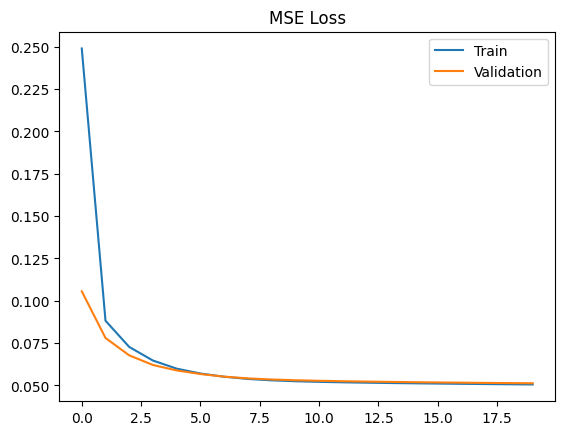

In [9]:
model = Model()
model.to(device)
#print(model(Jets[0].jet_features.to(device), Jets[0].trk_features.to(device))[0])
optimizer = optim.Adam(model.parameters(), lr=0.000001)
loss_fn = nn.MSELoss()
history = train(model, [Jets_training, Jets_validation])
plt.plot(history)
plt.title('MSE Loss')
plt.legend(['Train','Validation'])
plt.show()

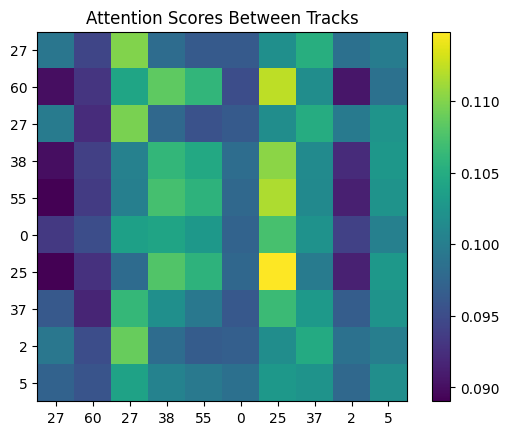

In [10]:
jet_no = 0

model.eval()
output, weights = model(Jets_testing[jet_no].jet_features.to(device), Jets_testing[jet_no].trk_features.to(device))
plt.imshow(weights.detach().cpu().numpy())
ticks = [x for x in range(len(Jets_testing[jet_no].trk_features))]
tick_labels = []
for trk in range(len(Jets_testing[jet_no].trk_features)):
    tick_labels.append(int(Jets_testing[jet_no].trk_labels[trk]))
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.colorbar()
plt.title("Attention Scores Between Tracks")
plt.show()

In [11]:
model.eval()
cumulative_loss_test = 0
predicted_labels = []
true_labels = []
for entry in Jets_testing:
    output, weights = model(entry.jet_features.to(device), entry.trk_features.to(device))
    predicted_labels.append(1-float(output[0].detach().cpu().numpy()))
    true_labels.append(1-float(entry.label[0].detach().numpy()))
    
    loss=loss_fn(output, entry.label.to(device))
    cumulative_loss_test+=loss.detach().cpu().numpy()
cumulative_loss_test = cumulative_loss_test / len(Jets_testing)
    
print(cumulative_loss_test)

0.05024229416667226


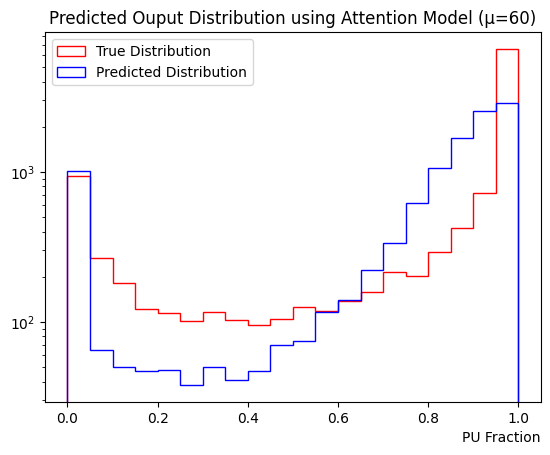

In [12]:
plt.hist(true_labels,histtype='step',color='r',label='True Distribution',bins=20,range=(0,1))
plt.hist(predicted_labels,histtype='step',color='b',label='Predicted Distribution',bins=20,range=(0,1))
plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()